In [1]:
from keras.layers import Bidirectional, Concatenate, Dot, Input, LSTM, RepeatVector, Dense, Activation
from keras.optimizers import Adam
from keras.activations import softmax
from keras.utils import to_categorical
from keras.models import load_model, Model
import numpy as np
import h5py
import matplotlib.pyplot as plt
from utils import string_to_int, int_to_string, plot_attention_map

/home/pablo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1 - Traducción de fechas a formato máquina

El modelo que se va a contruir puede ser utilizado para traducir de un lenguaje a otro, por ejemplo del inglés a francés. Sin embargo, la traducción de texto involucra la utilización de conjuntos de datos muy grandes y un tiempo largo de computo incluso utilizando GPUs. Se va a simplificar la traducción a sólo fechas con el objetivo de poder experimentar en un ordenador convencional. <p> <p>
La red tomará como input fechas escritas con diferentes formatos (ej: "the 29th of August 1958", "9 mayo 1998", "1998-05-09") y traducirlas a su formato máquina asociado (YYYY-MM-DD)
    

### 1.1 - Dataset

Entrenaremos el modelo sobre un conjunto de datos con 20000 fechas sin formato definido a su equivalente en formato máquina. Aproximadamente 10000 están escritas en castellano y las otras 10000 en español.

Cargamos los siguientes datos ya calculados:
- `dataset`: un array con  (fechas formato humano, fechas formato máquina)
- `input_vocab`: diccionario en Python que mapea todos los caracteres del vocabulario humano a un valor entero
- `output_vocab`: diccionario en Python que mapea todos los caracteres del vocabulario en formato fecha máquina a un valor entero
- `inv_output_vocab`: el diccionario inverso a output_bocab
- `X`: fechas en formato humano procesadas tal que cada caracter está mapeado al entero asociado en el vocabulario (input_vocab). Cada secuencia tiene una longitud aumentada con el caracter especial "pad" (#).
- `Y`: fechas en formato humano procesadas de manera análoga utilizando su vocabulario (output_vocab). 
- `Xoh`: one-hot version de X.
- `Yoh`: one-hot version de Y. 

In [2]:
dataset = np.load('data/data.npy')
print('Primeros 5 ejemplos de entrenamiento:')
print(dataset[:5])
X, Y = np.load('data/Xt.npy'), np.load('data/Yt.npy')

Primeros 5 ejemplos de entrenamiento:
[['9 mayo 1998' '1998-05-09']
 ['10.09.70' '1970-09-10']
 ['4/28/90' '1990-04-28']
 ['jueves enero 26 1995' '1995-01-26']
 ['lunes marzo 7 1983' '1983-03-07']]


In [3]:
# Xoh, Yoh = np.load('data/Xoh.npy'), np.load('data/Yoh.npy')
human_vocab = np.load('data/X_tok2idx.npy').item()
machine_vocab = np.load('data/Y_tok2idx.npy').item()
inv_machine_vocab = np.load('data/Y_idx2tok.npy').item()
Xoh = to_categorical(X, len(human_vocab))
Yoh = to_categorical(Y, len(machine_vocab))
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (20000, 28)
Y.shape: (20000, 10)
Xoh.shape: (20000, 28, 38)
Yoh.shape: (20000, 10, 11)


In [4]:
Tx = 28   # Tamaño de la secuencia de entrada
Ty = 10   # Tamaño de la secuencia de salida
m = 20000 # Número de ejemplos de entrenamiento

## 1.2 Neural machine translation model with attention

Supongamos que tenemos que traducir la secuencia, **"jueves 26 de enero de 1995"** a **"1995-01-26"**. Durante el proceso de lectura vamos enfocando la atención en partes de la secuencia de entrada para ir realizando la traducción en la secuencia de salida. El modelo que se implementa siguiente intenta simular este mecanismo de atención con la siguiente arquitectura de redes neuronales.

<table>
<td> 
<img src="nmt-images/attn.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> Neural machine translation with attention</center></caption>

Las ecuaciones que definen el mecanismo de atención son las siguientes:

$$e^{<i,j>} = v_{a}^{T}\tanh\big({W_{a}s_{i-1} + U_{a}h_{j}}\big)$$ <p>
$$\alpha^{<i,j>} = \dfrac{exp(e^{<i,j>})}{\sum_{k=1}^{T_x}exp(e^{<i,k>})}$$ 
$$context^{<i>} = \sum_{j = 0}^{T_x} \alpha^{<i,j>}h^{<j>}$$

Bahdanau et al., 2015

El contexto es una suma ponderada por los parámetros del modelo de atención de los "hidden states" de la bidireccional LSTM. Esto será el input de la LSTM final junto con el hidden, cell state de la anterior capa. Estos pesos deberán sumar uno y para ello utilizamos la función softmax propia siguiente:

In [5]:
def softmax_attention(x, axis=1):
    return softmax(x, axis=axis)

Las operaciones que se realizan para calcular las variables e pueden verse como capas densas de redes neuronales sin el termino "bias". Además de que para cada output puede vectorizarse la operación concatenando $s_{i-1}, h_{j}$ <p> Los parámetros asociados al modelo de atención serán compartidos por todas las capas, para ello utilizamos las siguientes variables globales de Keras:

In [6]:
repeator = RepeatVector(Tx, name='repeat_s') 
concatenator = Concatenate(axis=-1, name='concat_s_h')
tanh_layer = Dense(10, activation = "tanh", use_bias=False, name='tanh_layer')
v_layer = Dense(1, activation = "linear", use_bias=False, 
                kernel_initializer="zeros", name='v_layer')
softmax_layer = Activation(softmax_attention, name='attention_weights') 
context_layer = Dot(axes = 1, name='context_layer')

In [7]:
def one_step_attention(h, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    s_prev = repeator(s_prev)
    concat = concatenator([h, s_prev])
    e = v_layer(tanh_layer(concat))
    alphas = softmax_layer(e)
    context = context_layer([alphas, h])
    
    return context

Definimos los siguientes hyperparámetros y las capas LSTM que también comparten parámetros en toda la secuencia.

In [8]:
n_h = 48 # Número de hidden units cada una de las dos pre-attention pertenecientes a la BiLSTM.
n_s = 96   # Número de hidden units de la post-attention LSTM
#pre_attention_BiLSTM_cell = Bidirectional(LSTM(n_h, return_sequences=True), input_shape=(m, Tx, 2*n_h), name='Bi-LSTM')
pre_attention_BiLSTM_cell = Bidirectional(LSTM(n_h, return_sequences=True)) #, input_shape=(None, Tx, 38), name='Bi-LSTM')
post_attention_LSTM_cell = LSTM(n_s, return_state = True, name='post-attention-LSTM')
output_layer = Dense(len(machine_vocab), activation='softmax', name='softmax_output')

In [9]:
def model(Tx, Ty, n_h, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Inputs que recibirá nuestro modelo.
    X = Input(shape=(Tx, human_vocab_size), name='input_X')
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Outputs del modelo
    outputs = []
        
    # Primera capa que recibe como input el vector X,
    h = pre_attention_BiLSTM_cell(X)
    
    # Iteramos sobre la secencia del output para calcular el contexto y el output.
    for t in range(0, Ty):
        
        context = one_step_attention(h, s)
        s, _, c = post_attention_LSTM_cell(context, initial_state=[s, c])
        out = output_layer(s)
        outputs.append(out)
    
    # Creamos el modelo pasandole como argumento los inputs y los outputs
    model = Model(inputs=[X, s0, c0], outputs = outputs)
    
    return model

Definimos el modelo y mostramos el resumen de cada una de las capas y sus dimensiones.

In [10]:
model = model(Tx, Ty, n_h, n_s, len(human_vocab), len(machine_vocab))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_X (InputLayer)            (None, 28, 38)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 96)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 28, 96)       33408       input_X[0][0]                    
__________________________________________________________________________________________________
repeat_s (RepeatVector)         (None, 28, 96)       0           s0[0][0]                         
                                                                 post-attention-LSTM[0][0]        
          

El modelo tiene 110517 parámetros. Se dividen a grandes rasgos en:
- Bi-LSTM de entrada (33408)
- Attention (1930)
- LSTM de salida (74112)
- Softmax output (1067)

Definimos el algoritmo de optimización Adam siendo el la función objetivo la entropia sobre las 11 clases. Mostramos en cada iteración el accuracy sobre el conjunto de entrenamiento y validación.

In [11]:
opt = Adam(lr=0.005, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Tomamos el hidden state, cell state de la post-attention LSTM como el vector de ceros. <p> Convertimos el output Y en un tensor de dimensiones `(Ty, m, len(machine_vocab))`

In [12]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

El modelo ha sido entrenado con 30 epochs y cada batch con 100 ejemplos de entrenamiento.
El ordenador utilizado ha sido un CPU con 8GB de ram durante 20minutos.
Para ahorrar tiempo ya tenemos los pesos guardados y se va a realizar sólo un epoch sobre los pesos ya entrenados.

In [13]:
# model.fit([Xoh, s0, c0], outputs, epochs=30, batch_size=100)
# model.save_weights('models/weights_nmt.h5')

In [14]:
model.load_weights('weights/weights_nmt.h5')

In [15]:
# model.fit([Xoh, s0, c0], outputs, epochs=2, batch_size=50)

Epoch 1/1
20000/20000 [==============================] - 69s 3ms/step - loss: 1.1520 - softmax_output_loss: 0.2147 - softmax_output_acc: 0.9932 - softmax_output_acc_1: 0.9967 - softmax_output_acc_2: 0.9837 - softmax_output_acc_3: 0.9711 - softmax_output_acc_4: 0.9948 - softmax_output_acc_5: 0.9727 - softmax_output_acc_6: 0.9330 - softmax_output_acc_7: 0.9857 - softmax_output_acc_8: 0.9424 - softmax_output_acc_9: 0.9469

## 2 - Aplicación del modelo sobre ejemplos

In [16]:
EXAMPLES = ['3 May 1979', '5 April 2009', '21th of August 2016', '10 julio 2007', 
            'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 marzo 2001']
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))# .swapaxes(0,1) # .T.reshape(1,28, 37)
    #source = source.T.reshape(1, 28, 38)
    source = source.reshape(1, 28, 38)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 2009
output: 2009-04-05
source: 21th of August 2016
output: 2016-08-22
source: 10 julio 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 marzo 2001
output: 2001-03-01


## 3. Visualizar los pesos de la atención

Si observamos las capas de la red neuronal, la número 7 es la asociada a los pesos de la atención.

In [17]:
model.layers

Podemos visualizar el valor de estos pesos ($\alpha$) para distintos ejemplos.

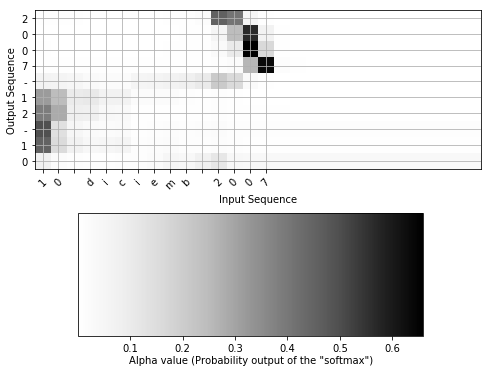

In [18]:
example = "10 diciemb 2007"
attention_map = plot_attention_map(model=model, input_vocabulary=human_vocab, inv_output_vocabulary=inv_machine_vocab, 
                                   text=example, num_layer=7, n_s=n_s, Tx=Tx, Ty=Ty);

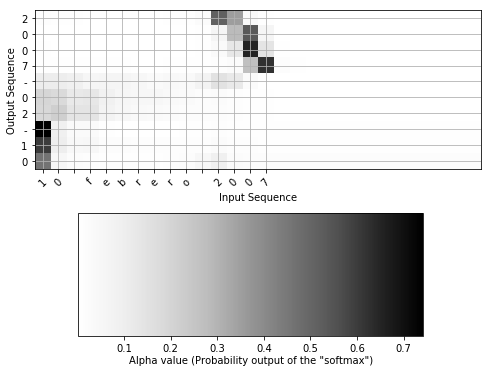

In [19]:
example = "10 febrero 2007"
attention_map = plot_attention_map(model=model, input_vocabulary=human_vocab, inv_output_vocabulary=inv_machine_vocab, 
                                   text=example, num_layer=7, n_s=n_s, Tx=Tx, Ty=Ty);

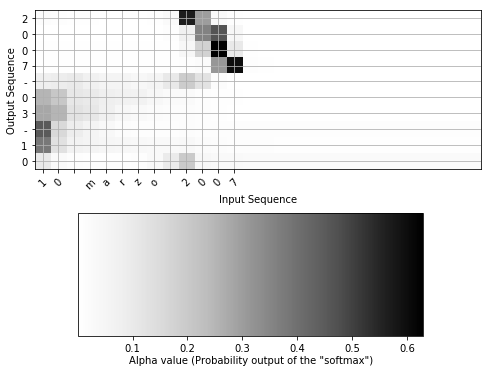

In [20]:
example = "10 marzo 2007"
attention_map = plot_attention_map(model=model, input_vocabulary=human_vocab, inv_output_vocabulary=inv_machine_vocab, 
                                   text=example, num_layer=7, n_s=n_s, Tx=Tx, Ty=Ty);

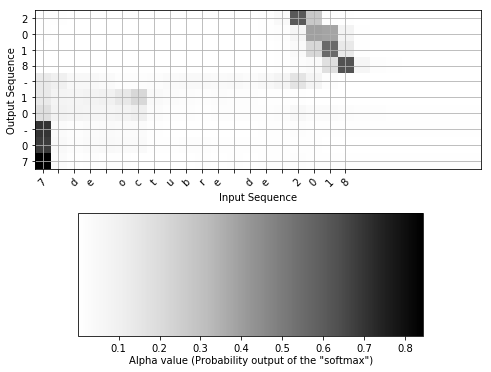

In [21]:
example = "7 de octubre de 2018"
attention_map = plot_attention_map(model=model, input_vocabulary=human_vocab, inv_output_vocabulary=inv_machine_vocab, 
                                   text=example, num_layer=7, n_s=n_s, Tx=Tx, Ty=Ty);

### References 
- I. Goodfellow, Y. Bengio, & A. Courville (2016). Deep Learning. MIT Press. http://www.deeplearningbook.org 
- A. Ng (2017). Deep Learning Specialization. Coursera. https://www.coursera.org/specializations/deep-learning 
- D. Bahdanau, K. Cho, and Y. Bengio (2014). Neural Machine Translation by Jointly Learning to Align and Translate. https://arxiv.org/abs/1409.0473
- HSE (2018). Natual Language Processing. Coursera. https://www.coursera.org/learn/language-processing 